In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import pickle
import re
import string
import numpy as np

import tensorflow as tf
print(tf.__version__)

import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from  nltk.stem import SnowballStemmer


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Activation, Embedding, Dropout, Flatten, MaxPooling1D, LSTM, Dense

2.2.0
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stop_words = stopwords.words("english")
stemmer =  SnowballStemmer("english")

embedding_dim = 100
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 1600000

In [ ]:
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ma', 'mightn', 'mustn', 'needn', 'shan']
print(len(stop_words))

144


In [ ]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

In [ ]:
#no need to run this cell as loaded preprocessed data is below
dataset_path = '/content/drive/My Drive/trainingandtestdata/training_cleaned.csv'
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [ ]:
#test data
dataset_path_test = '/content/drive/My Drive/trainingandtestdata/testdata.manual.2009.06.14.csv'
df_test = pd.read_csv(dataset_path_test, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

df_filtered = df_test[df_test['target'] != 2]  #as test data have 3 labels, 0:negative, 2:neutral, 4:positive, so removing neutral data


In [ ]:
#preprocessing functions
def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

def preprocess(line):
    line = line.lower()
    #stopwords removal
    for word in stop_words:
      token = " " + word + " "
      line = line.replace(token, " ")
      line = line.replace("  ", " ")
    #stemming   
    tokens = []
    for token in line.split():
      tokens.append(stemmer.stem(token))
    return " ".join(tokens)


In [ ]:
df.text = df.text.apply(lambda x: strip_links(x))
df.text = df.text.apply(lambda x: strip_all_entities(x))
#df.text = df.text.apply(lambda x: preprocess(x))

In [ ]:
df_new = df.drop(columns=['ids','date','flag','user'])
df_new = df_new.sample(frac=1).reset_index(drop=True)
df_new.head()

,target,text
0,0,Woodhaven keeps me from my one true love in li...
1,0,I think I m done with driving for the day I ve...
2,0,eating in Emirates lounge in Incheon airport S...
3,4,is watching taylor swift s making of the fearl...
4,0,How do I carry boxes home on a bike I can t Ha...


In [ ]:
sentence = df_new['text'].astype(str)
sentence = np.array(sentence)
y = df_new['target'].astype(float)

In [ ]:
df_new.to_csv('/content/drive/My Drive/preprocess_data.csv', index=False)

In [ ]:
#load cleaned data after preprocessing
df = pd.read_csv('/content/drive/My Drive/preprocess_data.csv')

sentence = df['text'].astype(str)
sentence = np.array(sentence)
y = df['target'].astype(float)

In [ ]:
#test data
df_filtered.text = df_filtered.text.apply(lambda x: strip_links(x))
df_filtered.text = df_filtered.text.apply(lambda x: strip_all_entities(x))
#df_filtered.text = df_filtered.text.apply(lambda x: preprocess(x))

df_t = df_filtered.drop(columns=['ids','date','flag','user'])
df_t['text'] = df_t['text'].astype(str)
df_t['target'] = df_t['target'].astype(float)

x_test = df_t['text'].astype(str)
x_test = np.array(x_test)
y_test = df_t['target'].astype(float)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
#tokenizer

tokenizer= Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(sentence)
#saving tokenizer
pickle.dump(tokenizer, open("/content/drive/My Drive/sentiment analysis/tokenizerfinal.p", "wb"))
#load tokenizer
tokenizer = pickle.load(open("/content/drive/My Drive/sentiment analysis/tokenizerfinal.p", "rb"))

word_index = tokenizer.word_index
#save word_index
pickle.dump(word_index, open("/content/drive/My Drive/sentiment analysis/word_indexfinal.p", "wb"))
#load word_index
word_index = pickle.load(open("/content/drive/My Drive/sentiment analysis/word_indexfinal.p", "rb"))
vocab_size=len(word_index)
print(vocab_size)

293998


In [ ]:
#print(vocab_size)
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding = padding_type, truncating=trunc_type)

In [ ]:
#test data 
t_seq = tokenizer.texts_to_sequences(x_test)
t_pad = pad_sequences(t_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

y_test = y_test/4.0
test_seq = t_pad


In [ ]:
#no need of this if we are not training model

train_val_split = int(0.9 * training_size)

train_sequences = padded[0:train_val_split] 
val_sequences = padded[train_val_split:]
train_labels  = y[0:train_val_split] 
val_labels = y[train_val_split:]
train_labels= train_labels/4.0              #positive labels were 4.0. so, making them 1.0
val_labels = val_labels/4.0

#no need of this if we are not training model
train_val_split = int(0.9 * training_size)

train_sequences = padded[0:train_val_split] 
val_sequences = padded[train_val_split:]
train_labels  = y[0:train_val_split] 
val_labels = y[train_val_split:]
train_labels= train_labels/4.0              #positive labels were 4.0. so, making them 1.0
val_labels = val_labels/4.0

In [ ]:
#no need to run this as we already have saved model

# Note this is the 100 dimension version of GloVe from Stanford
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt


  #  http://nlp.stanford.edu/data/wordvecs/glove.6B.zip



embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as file:
    for line in file:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-06-28 04:52:59--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 209.85.146.128, 74.125.124.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   119MB/s    in 2.8s    

2020-06-28 04:53:02 (119 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [ ]:
#mdoel training

model = tf.keras.Sequential([
   tf.keras.layers. Embedding(vocab_size+1, embedding_dim, weights=[embeddings_matrix], input_length=max_length, trainable=False),
   tf.keras.layers.Dropout(0.3), 
   tf.keras.layers.Conv1D(128, 5, activation='relu'),
   tf.keras.layers.MaxPooling1D(pool_size=4),
   tf.keras.layers.Conv1D(256, 3, activation='relu'),
   tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy') 
model.summary()

num_epochs = 20
history = model.fit(train_sequences, train_labels, batch_size = 1024, epochs=num_epochs,steps_per_epoch=200, validation_data=(val_sequences, val_labels), verbose=2)

print("Complete")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          29399900  
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 24, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 22, 256)           98560     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 11, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)              

In [ ]:
#save model
model.save('/content/drive/My Drive/sentiment analysis/model7880')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/sentiment analysis/model7880/assets


<Figure size 432x288 with 0 Axes>

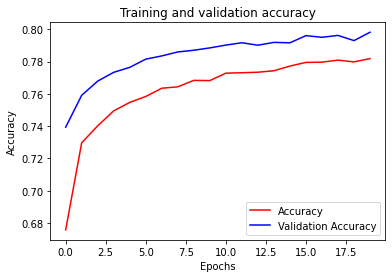

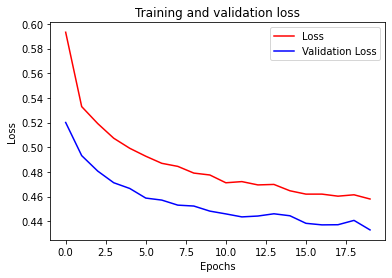

<Figure size 432x288 with 0 Axes>

In [ ]:
#plot of training
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()


plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()



In [ ]:
#saving as json file
import json
model_json = model.to_json()
with open("/content/drive/My Drive/sentiment analysis/model2.json", "w") as json_file:
  json_file.write(model_json)
model.save_weights("/content/drive/My Drive/sentiment analysis/model2.h5")
print("saved to drive as json file")

saved to drive as json file


In [ ]:
#load model

model = tf.keras.models.load_model('/content/drive/My Drive/sentiment analysis/model7880')

In [ ]:
#test data evaluation
score = model.evaluate(test_seq, y_test, batch_size=64)

6/6 [==============================] - 0s 29ms/step - loss: 0.3842 - accuracy: 0.8217


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#conclusion 
import re
import string
import numpy as np
import pickle

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from  nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")

embedding_dim = 100
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ma', 'mightn', 'mustn', 'needn', 'shan']
#stop_words = ['list of stop words'] # i'll provide this

def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

def preprocess(line):
    line = line.lower()
    #stopwords removal
    for word in stop_words:
      token = " " + word + " "
      line = line.replace(token, " ")
      line = line.replace("  ", " ")
    #stemming   
    tokens = []
    for token in line.split():
      tokens.append(stemmer.stem(token))
    return " ".join(tokens)


tokenizer= Tokenizer(oov_token=oov_tok)
tokenizer = pickle.load(open("/content/drive/My Drive/sentiment analysis/tokenizerfinal.p", "rb"))
##word_index = pickle.load(open("/content/drive/My Drive/sentiment analysis/wordindex.p", "rb"))    #these two lines can be omitted, just kept here to see word word index
##vocab_size = len(word_index)
model = tf.keras.models.load_model('/content/drive/My Drive/sentiment analysis/model7880')


i current use nikon d90 love not much canon 40d 50d chose d90 video featur mistak
[[    2   793   102  6647 16871     9   201    44  4610 27648 25433  3692
  16871   252  1438  1723     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
1/1 - 0s
[0.75352895]
positive


In [ ]:
def predict(twt):
  twt = strip_links(twt)    #optional
  twt = strip_all_entities(twt)  #optional (it removes @username #name)
  print(twt)
  ls = []
  ls.append(twt)
  twt = tokenizer.texts_to_sequences(ls)
  twt = pad_sequences(twt, maxlen=max_length, padding = padding_type, truncating=trunc_type)
  #print(twt)
  sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
  ans = np.around(sentiment)
  print(sentiment)
  if ans ==1:
    print('positive')
  else:
    print('negative')

In [ ]:
predict('you are pretty ugly')

NameError: ignored